#### Set UP:

In [1]:
!pip install h5py
!pip install openai
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 9.5 MB/s eta 0:00:00


In [2]:
import h5py    
import numpy as np
import transformers
import matplotlib.pyplot as plt
import pandas as pd
from transformers import AutoTokenizer, pipeline
import torch
import re
from tqdm import tqdm
import csv

2024-05-12 22:30:22.224294: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 22:30:22.224406: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 22:30:22.357767: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## DownLoad Dataset:

In [3]:
filename = "/kaggle/input/fashiongen-validation/fashiongen_256_256_train.h5"
dataset = h5py.File(filename,'r')

In [4]:
for key, value in dataset.items():
    print(f"Dataset Name: {key}")
    print(f"Dataset Content: {value}")
    print()

Dataset Name: index
Dataset Content: <HDF5 dataset "index": shape (260490, 1), type "<i8">

Dataset Name: index_2
Dataset Content: <HDF5 dataset "index_2": shape (260490,), type "<i8">

Dataset Name: input_brand
Dataset Content: <HDF5 dataset "input_brand": shape (260490, 1), type "|S100">

Dataset Name: input_category
Dataset Content: <HDF5 dataset "input_category": shape (260490, 1), type "|S100">

Dataset Name: input_composition
Dataset Content: <HDF5 dataset "input_composition": shape (260490, 1), type "|S200">

Dataset Name: input_concat_description
Dataset Content: <HDF5 dataset "input_concat_description": shape (260490, 1), type "|S800">

Dataset Name: input_department
Dataset Content: <HDF5 dataset "input_department": shape (260490, 1), type "|S100">

Dataset Name: input_description
Dataset Content: <HDF5 dataset "input_description": shape (260490, 1), type "|S400">

Dataset Name: input_gender
Dataset Content: <HDF5 dataset "input_gender": shape (260490, 1), type "|S30">

Datas

In [5]:
gender = dataset['input_gender'][:]
category = dataset['input_category'][:]
description = dataset['input_description'][:]
pose = dataset['input_pose'][:]
subcategory = dataset['input_subcategory'][:]
df = pd.DataFrame({
    'gender': gender.flatten(),
    'category': category.flatten(),
    'description': description.flatten(),
    'pose': pose.flatten(),
    'subcategory': subcategory.flatten()
})
pose_ids_to_exclude = [b'id_gridfs_3', b'id_gridfs_5', b'id_gridfs_6', b'id_gridfs_2']

df = df[~df['pose'].isin(pose_ids_to_exclude)]
print(df.head())

     gender     category                                        description  \
0    b'Men'    b'SHIRTS'  b'Long sleeve coated denim shirt in indigo blu...   
3    b'Men'    b'SHIRTS'  b'Long sleeve coated denim shirt in indigo blu...   
4  b'Women'  b'SWEATERS'  b'Long sleeve sweatshirt in heather grey. Band...   
7  b'Women'  b'SWEATERS'  b'Long sleeve sweatshirt in heather grey. Band...   
8  b'Women'     b'JEANS'  b'Skinny-fit jeans in indigo. Turquoise overdy...   

             pose          subcategory  
0  b'id_gridfs_1'            b'SHIRTS'  
3  b'id_gridfs_4'            b'SHIRTS'  
4  b'id_gridfs_1'  b'HOODIES & ZIPUPS'  
7  b'id_gridfs_4'  b'HOODIES & ZIPUPS'  
8  b'id_gridfs_1'             b'JEANS'  


In [6]:
df

,gender,category,description,pose,subcategory
0,b'Men',b'SHIRTS',b'Long sleeve coated denim shirt in indigo blu...,b'id_gridfs_1',b'SHIRTS'
3,b'Men',b'SHIRTS',b'Long sleeve coated denim shirt in indigo blu...,b'id_gridfs_4',b'SHIRTS'
4,b'Women',b'SWEATERS',b'Long sleeve sweatshirt in heather grey. Band...,b'id_gridfs_1',b'HOODIES & ZIPUPS'
7,b'Women',b'SWEATERS',b'Long sleeve sweatshirt in heather grey. Band...,b'id_gridfs_4',b'HOODIES & ZIPUPS'
8,b'Women',b'JEANS',b'Skinny-fit jeans in indigo. Turquoise overdy...,b'id_gridfs_1',b'JEANS'
...,...,...,...,...,...
260481,b'Women',b'SHORTS',"b""Denim shorts in 'with the band' white. Mid-r...",b'id_gridfs_4',b'SHORTS'
260482,b'Men',b'JEANS',b'Tapered raw denim jeans in indigo. Mid-rise....,b'id_gridfs_1',b'JEANS'
260485,b'Men',b'JEANS',b'Tapered raw denim jeans in indigo. Mid-rise....,b'id_gridfs_4',b'JEANS'
260486,b'Men',b'PANTS',b'Relaxed-fit stretch cotton trousers featurin...,b'id_gridfs_1',b'TROUSERS'


## Data Preprocess:

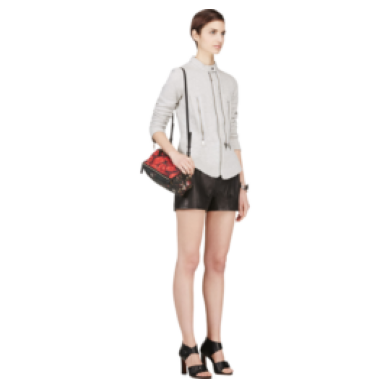

In [7]:
import matplotlib.pyplot as plt

plt.imshow(dataset['input_image'][7])
plt.axis('off')  
plt.show()

In [8]:
df['pose'] = df['pose'].apply(lambda x: b'front pose' if x == b'id_gridfs_1' else (b'full pose' if x == b'id_gridfs_4' else x))
df['final_description']=df['pose']+b' of '+ df['subcategory']+ b' for '+df['gender']+b'. '+df['description']
df['category'] = df['category'].str.decode('utf-8').str.lower().str.replace('\ufffd', '')
#df['category'] = df['category'].str.decode('utf-8', errors='replace').str.lower().str.replace('\ufffd', '')

In [9]:
df["final_description"]

0         b'front pose of SHIRTS for Men. Long sleeve co...
3         b'full pose of SHIRTS for Men. Long sleeve coa...
4         b'front pose of HOODIES & ZIPUPS for Women. Lo...
7         b'full pose of HOODIES & ZIPUPS for Women. Lon...
8         b'front pose of JEANS for Women. Skinny-fit je...
                                ...                        
260481    b"full pose of SHORTS for Women. Denim shorts ...
260482    b'front pose of JEANS for Men. Tapered raw den...
260485    b'full pose of JEANS for Men. Tapered raw deni...
260486    b'front pose of TROUSERS for Men. Relaxed-fit ...
260489    b'full pose of TROUSERS for Men. Relaxed-fit s...
Name: final_description, Length: 118116, dtype: object

In [10]:
df["final_description"][8]

b'front pose of JEANS for Women. Skinny-fit jeans in indigo. Turquoise overdye effect throughout. Five-pocket styling. Logo flag and black leather trim at coin pocket. Distressing at front. Leather logo patch at back waistband in grey. Tonal stitching. Zip-fly.'

In [11]:
print(df.isnull().sum())

gender               0
category             0
description          0
pose                 0
subcategory          0
final_description    0
dtype: int64


In [12]:
df

,gender,category,description,pose,subcategory,final_description
0,b'Men',shirts,b'Long sleeve coated denim shirt in indigo blu...,b'front pose',b'SHIRTS',b'front pose of SHIRTS for Men. Long sleeve co...
3,b'Men',shirts,b'Long sleeve coated denim shirt in indigo blu...,b'full pose',b'SHIRTS',b'full pose of SHIRTS for Men. Long sleeve coa...
4,b'Women',sweaters,b'Long sleeve sweatshirt in heather grey. Band...,b'front pose',b'HOODIES & ZIPUPS',b'front pose of HOODIES & ZIPUPS for Women. Lo...
7,b'Women',sweaters,b'Long sleeve sweatshirt in heather grey. Band...,b'full pose',b'HOODIES & ZIPUPS',b'full pose of HOODIES & ZIPUPS for Women. Lon...
8,b'Women',jeans,b'Skinny-fit jeans in indigo. Turquoise overdy...,b'front pose',b'JEANS',b'front pose of JEANS for Women. Skinny-fit je...
...,...,...,...,...,...,...
260481,b'Women',shorts,"b""Denim shorts in 'with the band' white. Mid-r...",b'full pose',b'SHORTS',"b""full pose of SHORTS for Women. Denim shorts ..."
260482,b'Men',jeans,b'Tapered raw denim jeans in indigo. Mid-rise....,b'front pose',b'JEANS',b'front pose of JEANS for Men. Tapered raw den...
260485,b'Men',jeans,b'Tapered raw denim jeans in indigo. Mid-rise....,b'full pose',b'JEANS',b'full pose of JEANS for Men. Tapered raw deni...
260486,b'Men',pants,b'Relaxed-fit stretch cotton trousers featurin...,b'front pose',b'TROUSERS',b'front pose of TROUSERS for Men. Relaxed-fit ...


## Falcon --> for generate instruction :

In [13]:
model = "tiiuae/falcon-7b-instruct"
tokenizer = AutoTokenizer.from_pretrained(model)
pipeline = transformers.pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
    device_map="auto",
    truncation=True,  
    pad_token_id=tokenizer.eos_token_id 
)

tokenizer_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.73M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/281 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

configuration_falcon.py:   0%|          | 0.00/7.16k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-7b-instruct:
- configuration_falcon.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_falcon.py:   0%|          | 0.00/56.9k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-7b-instruct:
- modeling_falcon.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin.index.json:   0%|          | 0.00/16.9k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/4.48G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

## Statistical Instructions :

In [ ]:
'''from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')

def calculate_similarity(text1, text2):
    stop_words = set(stopwords.words('english'))
    word_tokens1 = [word.lower() for word in word_tokenize(text1) if word.lower() not in stop_words]
    word_tokens2 = [word.lower() for word in word_tokenize(text2) if word.lower() not in stop_words]
    common_words = set(word_tokens1) & set(word_tokens2)
    similarity_score = len(common_words) / (len(set(word_tokens1)) + len(set(word_tokens2)))
    return similarity_score

top_instruction = []
filename_output = "/kaggle/working/generated_instruction-1.csv"
encodings = ['utf-8', 'latin-1', 'windows-1252']  

decoded_descriptions = {}
for idx, desc in df['final_description'].items():
    try:
        decoded = desc.decode('utf-8')  
    except UnicodeDecodeError:
        for encoding in encodings[1:]: 
            try:
                decoded = desc.decode(encoding)
                break  
            except UnicodeDecodeError:
                pass 
    decoded_descriptions[idx] = decoded
with open(filename_output, 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['image_index', 'Description', 'Generated Instructions']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    
    for idx, description in decoded_descriptions.items():
        generated_instructions = []
        matched_instructions = []

        sequences = pipeline(
                f"Can you create instructions to modify the given description : '{description}', like changing the color of a garment that exists in the given text to a different specific color, changing the fabric of a garment in the outfit to another facbric you are free to choose one, remove or add an item if it exists, or anything else that the user can add if it doesn't exist in the description and make the instruction specific for each given text. All of these are created based on the given description. I would like the instructions each one on a separate line. Instructions: \n\n",
                max_length=300,
                do_sample=True,
                top_k=10,
                temperature=0.1,
                top_p=0.9,
                no_repeat_ngram_size=4,
                repetition_penalty=2.0,
                num_return_sequences=1,
                eos_token_id=tokenizer.eos_token_id,
            )
        generated_text = sequences[0]['generated_text']
        instruction_index = generated_text.find("Instructions: \n\n")  
        if instruction_index != -1:  
            generated_instructions_text = generated_text[instruction_index + len("Instructions: \n\n"):]
            generated_instructions_list = generated_instructions_text.split("\n")
            
            similarity_scores = [calculate_similarity(description, instr) for instr in generated_instructions_list]
            
            instructions_with_scores = list(zip(generated_instructions_list, similarity_scores))
            instructions_with_scores.sort(key=lambda x: x[1], reverse=True)
            
            top_instructions = instructions_with_scores[:2]
            top_instructions_text = [instr[0] for instr in top_instructions]
            #print(top_instructions_text)

        print(idx)
        writer.writerow({'image_index': idx, 'Description': description, 'Generated Instructions': top_instructions_text})'''

In [15]:
def select_unique_instructions(instructions, num_instructions=4):
    unique_instructions = []
    seen_instructions = set()

    for instruction in instructions:
        clean_instruction = instruction.strip().lower()
        if clean_instruction not in seen_instructions:
            unique_instructions.append(instruction)
            seen_instructions.add(clean_instruction)
        if len(unique_instructions) == num_instructions:
            break
    return unique_instructions

In [ ]:
import re
def extract_instructions(instructions):
    extracted_instructions = []
    for instruction in instructions:
        matches = re.findall(r'(Change|Add|Remove)\s*(.*?)\s*(to|from|of)?\s*(.*)', instruction)
        for match in matches:
            formatted_instruction = " ".join(match).strip()
            extracted_instructions.append(formatted_instruction)
    return extracted_instructions

top_instruction = []
filename_output = "/kaggle/working/generated_instruction-1.csv"
encodings = ['utf-8', 'latin-1', 'windows-1252']  

decoded_descriptions = {}
for idx, desc in df['final_description'].items():
    try:
        decoded = desc.decode('utf-8')  
    except UnicodeDecodeError:
        for encoding in encodings[1:]: 
            try:
                decoded = desc.decode(encoding)
                break  
            except UnicodeDecodeError:
                pass 
    decoded_descriptions[idx] = decoded
resume_index = 0
with open(filename_output, 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['image_index', 'Description', 'Generated Instructions']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    
    for idx, description in decoded_descriptions.items():
        if idx < resume_index:
            continue
        generated_instructions = []
        matched_instructions = []
        print(description)

        sequences = pipeline(
                f"Can you create instructions to modify the given description : '{description}', like changing the color of a garment that exists in the given text to a different specific color, changing the fabric of a garment in the outfit to another facbric you are free to choose one, remove or add an item if it exists, or anything else that the user can add if it doesn't exist in the description and make the instruction specific for each given text. All of these are created based on the given description. I would like the instructions each one on a separate line. Instructions: \n\n",
                max_length=300,
                do_sample=True,
                top_k=10,
                temperature=0.1,
                top_p=0.9,
                no_repeat_ngram_size=4,
                repetition_penalty=2.0,
                num_return_sequences=1,
                eos_token_id=tokenizer.eos_token_id,
            )
        generated_text = sequences[0]['generated_text']
        instruction_index = generated_text.find("Instructions: \n\n")  
        if instruction_index != -1:  
            generated_instructions_text = generated_text[instruction_index + len("Instructions: \n\n"):]
            generated_instructions_list = generated_instructions_text.split("\n")
            top_instructions_text = extract_instructions(generated_instructions_list)
            top_instructions = select_unique_instructions(top_instructions_text)
            print(top_instructions_text)
            print(top_instructions)

        print(idx)
        writer.writerow({'image_index': idx, 'Description': description, 'Generated Instructions': top_instructions})

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


front pose of SHIRTS for Men. Long sleeve coated denim shirt in indigo blue. Irregular overdye effect throughout in black. Spread collar. Flap pockets at breast, one with metallic logo piece. Press-stud closure at front. Tonal stitching. Three press-studs at barrel cuffs.
['Change   the color of the shirt from indigo blue to black', 'Change   the fabric of the shirt to a different fabric', 'Remove   the metallic logo piece', 'Add   a specific fabric to the shirt', 'Remove   or add an existing pocket', 'Change   any other existing item in the outfit', 'Change   the color by selecting a different color from the dropdown menu.', 'Change   the fabric by selecting a specific fabric from the dropdown list.', 'Remove   the metallic silver logo piece by clicking on the logo and selecting "remove".', 'Add   a specific material']
['Change   the color of the shirt from indigo blue to black', 'Change   the fabric of the shirt to a different fabric', 'Remove   the metallic logo piece', 'Add   a spe

--- Logging error ---
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/logging/__init__.py", line 1100, in emit
    msg = self.format(record)
  File "/opt/conda/lib/python3.10/logging/__init__.py", line 943, in format
    return fmt.format(record)
  File "/opt/conda/lib/python3.10/logging/__init__.py", line 678, in format
    record.message = record.getMessage()
  File "/opt/conda/lib/python3.10/logging/__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 104

['Change   the color of the garment to black', 'Change   the fabric of the garment from denim to silk', 'Remove   the embroidery and replace it with a solid colored fabric', 'Add   a pocket watch chain to the garment', 'Add   two belt loops to the garment', 'Add   a leather belt to the garment']
['Change   the color of the garment to black', 'Change   the fabric of the garment from denim to silk', 'Remove   the embroidery and replace it with a solid colored fabric', 'Add   a pocket watch chain to the garment']
20
full pose of TROUSERS for Men. Relaxed-fit textured trousers with embroidery, crumpling and distressed effects in metallic grey. Denim weave and light tonal sparkle effect throughout. Deconstructed embroidery detail at left hip. Coin pocket and riveted jean pocket in front. Welt pockets and patch pockets in back. Crumpling at cuff. Button fly.
['Change   the color of the garment to a specific color.', 'Change   the']
['Change   the color of the garment to a specific color.', '